In [411]:
# This is a long process, so have it separate from the other pip installations.

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -r requirements.txt

     ---------------------------------------- 9.1/9.1 MB 25.4 MB/s eta 0:00:00
     ---------------------------------------- 233.7/233.7 KB ? eta 0:00:00


In [502]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
#%matplotlib notebook

In [156]:
import seaborn as sn

def plot_correlation(df):

    fig, ax = plt.subplots(1, 1, figsize=(len(df.columns), len(df.columns)), dpi=100)
    sn.heatmap(df.corr(), annot=True, ax=ax)
    ax.set_title('Correlation Matrix')
    return plt.gcf()

In [273]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    #print(history.params)
    #print(history.history.keys())

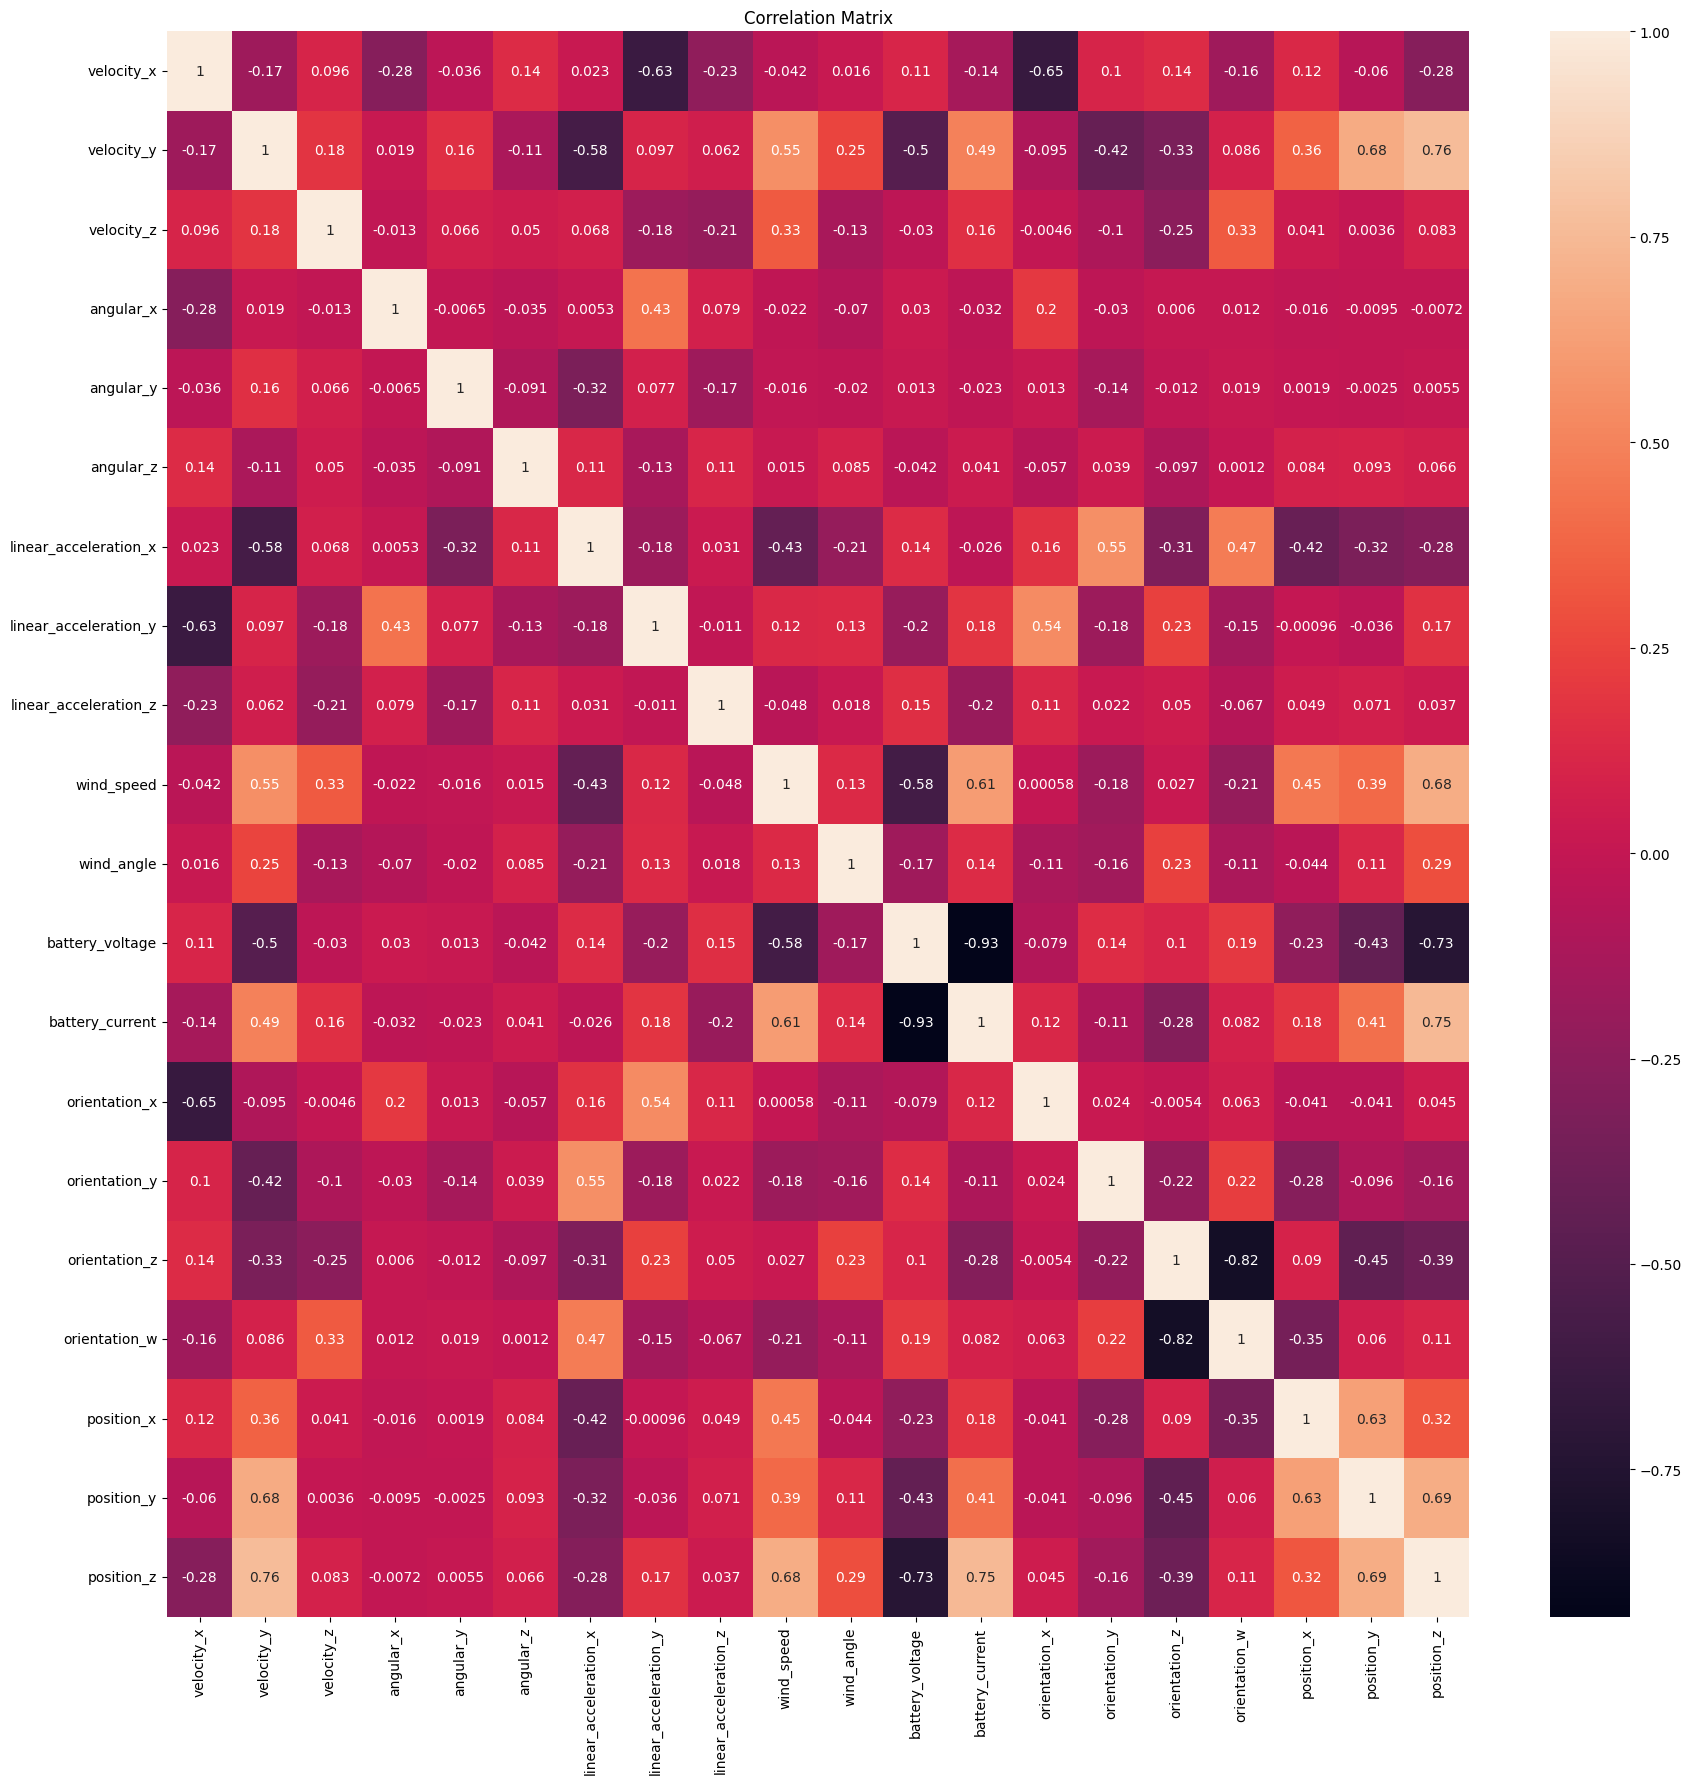

In [499]:
# Load Data
uav = pd.read_csv('uav_flight_data.csv')
# This should be the miminum information required, but for a single flight it does not do well
#fields = ['angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'position_z']
# Adding in the wind speed and battery information, the model performs much, much better.
#fields = ['angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed', 'wind_angle', 'battery_voltage', 'battery_current', 'position_z']
# Now with everyone!  This produced a great plot!!!  There must be non-correlated (?) information between the accel and vel terms.
inputs = ['velocity_x', 'velocity_y', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed', 'wind_angle', 'battery_voltage', 'battery_current', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']
outputs = ['position_x', 'position_y', 'position_z']

# TODO: Read the datetime from the parameters file
start = dt.datetime(year=2015,month=1,day=1)
uav['time'] = uav['time'] + start.timestamp()
uav["time"] = pd.to_datetime(uav["time"], unit='s')

uav = uav[['time', *inputs, *outputs]]

# Do I still need this for this clean dataset?
uav.fillna(uav.bfill())

# Extract the training and test datasets
train = uav[:int(len(uav)*0.8)]
test = uav[int(len(uav)*0.8):]

corr = uav.corr()
'''
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
#selected_columns = uav.columns[columns]
print(columns)
'''

fig = plot_correlation(uav)

Index(['time', 'velocity_x', 'velocity_y', 'velocity_z', 'angular_x',
       'angular_y', 'angular_z', 'linear_acceleration_x',
       'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed',
       'wind_angle', 'battery_voltage', 'battery_current', 'orientation_x',
       'orientation_y', 'orientation_z', 'orientation_w', 'position_x',
       'position_y', 'position_z'],
      dtype='object')
Index(['velocity_x', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_y', 'linear_acceleration_z', 'wind_angle',
       'orientation_x', 'orientation_y'],
      dtype='object')


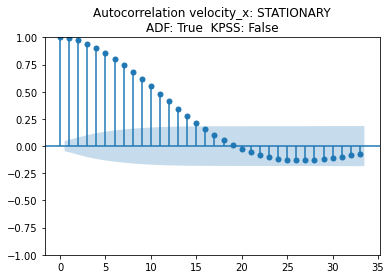

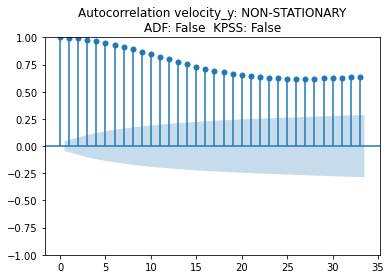

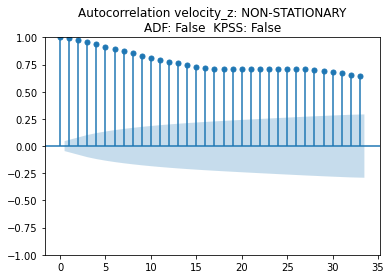

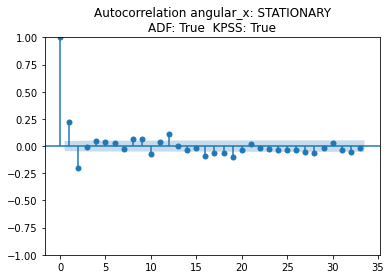

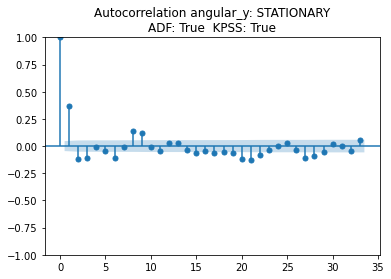

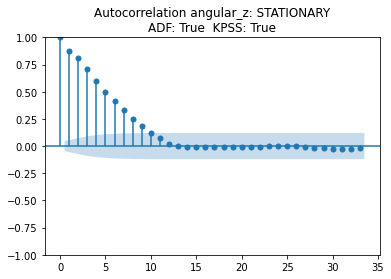

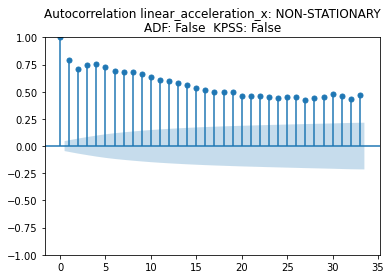

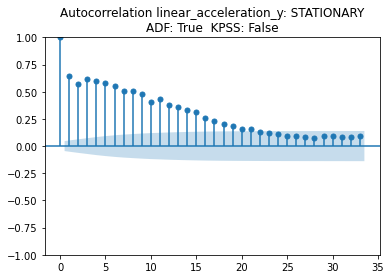

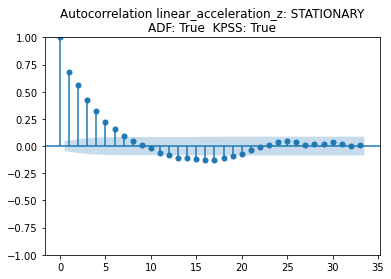

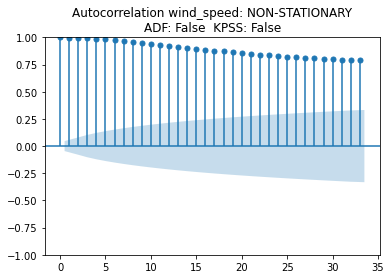

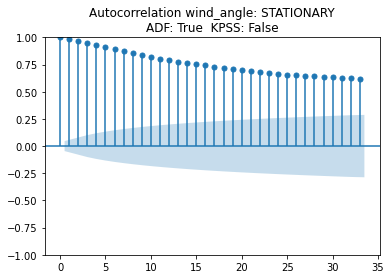

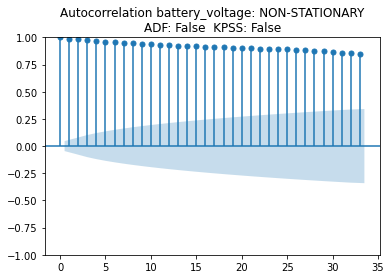

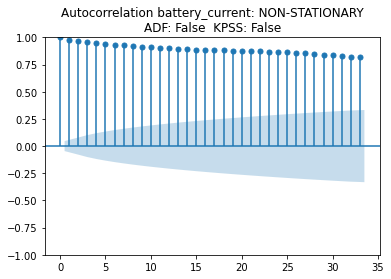

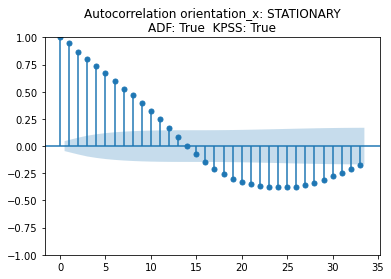

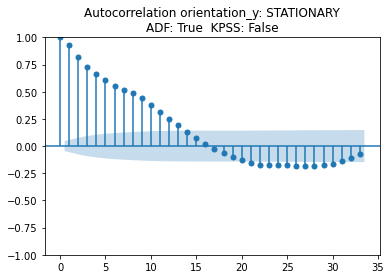

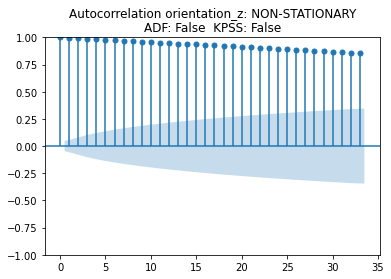

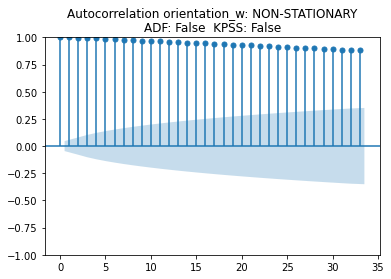

In [503]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller, kpss

## Test the stationarity of a time series.  ADF is a 'Unit Root Test'
## https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

#inputs = ['wind_angle']
#inputs = ['velocity_z']
stationary = []

for field in inputs:
    title = f'Autocorrelation {field}: '
    ret_adf = adfuller(uav[field])
    ret_kpss = kpss(uav[field], regression='ct')

    pass_adf = ret_adf[1] <= 0.05 and ret_adf[0] < min(result[4].values())
    pass_kpss = ret_kpss[1] > 0.05

    if pass_adf or pass_kpss:
        title += f'STATIONARY\nADF: {pass_adf}  KPSS: {pass_kpss}'
        stationary.append(field)
    else:
        title += f'NON-STATIONARY\nADF: {pass_adf}  KPSS: {pass_kpss}'

    if False:
        print(f'Series ({field})')
        print('ADF Statistic: %f' % ret_adf[0])
        print('p-value: %f' % ret_adf[1])
        print('Critical Values:')
        for key, value in ret_adf[4].items():
            print('\t%s: %.3f' % (key, value))
        print('KPSS Statistic: %f' % ret_kpss[0])
        print('p-value: %f' % ret_kpss[1])
        print('Critical Values:')
        for key, value in ret_kpss[3].items():
            print('\t%s: %.3f' % (key, value))
            
    fig = tsaplots.plot_acf(uav[field], title=title)
    #plt.show()


uav = uav[stationary]


In [508]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = np.array(scaler.fit_transform(train[[*inputs, *outputs]]))
print('Scaled Data Shape: ', scaled_data.shape)

#plt.plot(scaled_data)
#plt.show()

window_sample_size = int(len(scaled_data) / 20)
#window_sample_size = 10
print('Window sample size: ', window_sample_size)

# NOTE: We are only going to use ACCEL_Z predict POS_Z to keep the problem univariate
x_train = []
y_train = []
# Build the sliding window of samples (find the technical word for this ... maybe in sktime?)
for x in range(window_sample_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_sample_size:x, : -len(outputs)])
    y_train.append(scaled_data[x, -len(outputs):])

x_train, y_train = np.array(x_train), np.array(y_train)
print('X Train Data Shape: ', x_train.shape)
print('Y Train Data Shape: ', y_train.shape)


Scaled Data Shape:  (1447, 20)
Window sample size:  72
X Train Data Shape:  (1375, 72, 17)
Y Train Data Shape:  (1375, 3)


In [ ]:
# Build The Model
model = Sequential()

model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1:])))
model.add(Dropout(0.4))
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=len(outputs))) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

## Need to figure out how the data size and the batch_size work ... need to optimize for a GPU system.  Higher batch size works much better on the GPU (less overhead)
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
plot_history(history)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_207 (LSTM)             (None, 72, 128)           74752     
                                                                 
 dropout_200 (Dropout)       (None, 72, 128)           0         
                                                                 
 lstm_208 (LSTM)             (None, 72, 128)           131584    
                                                                 
 dropout_201 (Dropout)       (None, 72, 128)           0         
                                                                 
 lstm_209 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_202 (Dropout)       (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 3)               

In [ ]:
### Test the Model Accuracy on Existing Data ###
################################################

# Build the test data
x_test = []
#len(total_temp)-len(test)-prediction_days
for x in range(window_sample_size, len(scaled_data)-window_sample_size):
    x_test.append(scaled_data[x-window_sample_size:x, :-len(outputs)])
x_test = np.array(x_test)
print('X Test Data Shape: ', x_test.shape)

# Make Predictions on Test Data
pred = model.predict(x_test)
print('Predictions:\n', pred[:][:10])

#np.append(x_test, pred)
#print('X Test Data Shape: ', x_test.shape)
#pred = scaler.inverse_transform(x_test)
#print('Inverse Transformed Predictions\n', pred[:][:10])

#from sklearn.metrics import mean_absolute_error
#mean_absolute_error(test['Avg_Temp'], pred)

In [ ]:
### Visualization ###
#####################
'''
pred_ = pd.DataFrame(test['time'])
pred_['position_x'] = pred
pred_["time"] = pd.to_datetime(pred_["time"])
print(pred_)
original = florida.loc[florida['Date'] >= '1990-01-01']
'''

import seaborn as sns

for i in list(range(0, len(outputs))):
    plt.subplot(len(outputs), 1, i+1)
    sns.lineplot(x=list(range(0, len(pred)+window_sample_size)), y=np.append(np.ones(window_sample_size)*pred[0, i], pred[:, i]))
    sns.lineplot(x=list(range(0, len(scaled_data))), y=scaled_data[:, -len(outputs)+i])
    plt.show()